# To do
1. Check if RITA and Potts can run locally

In [80]:
%load_ext autoreload
%autoreload 2

import os
import joblib
from pathlib import Path
from tempfile import TemporaryDirectory
from loguru import logger

import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from predictability.models import RITARegressor, PottsRegressor
from predictability.utils import update_environment_variables, assign_ssm_folds
from predictability.sm_utils import get_rita_embeddings, get_potts_emissions
from predictability.constants import DATA_ROOT, PROJECT_ROOT

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
update_environment_variables("zsh")
DEFAULT_BUCKET = os.environ.get("AWS_DEFAULT_BUCKET")
SEED = 1337
n_folds = 10
lambda_values = [0.001, 0.01, 0.1, 0.9]

In [82]:
datasets = [
    "CASP3_HUMAN_Roychowdhury_2020",
    "MK01_HUMAN_Brenan_2016",
    "AMIE_PSEAE_Wrenbeck_2017",
    "UBC9_HUMAN_Weile_2017",
    "SRC_HUMAN_Ahler_2019",
    "BLAT_ECOLX_Deng_2012",
    "BLAT_ECOLX_Stiffler_2015",
    "PTEN_HUMAN_Mighell_2018",
    "BLAT_ECOLX_Firnberg_2014"
]

In [91]:
rita_training_job_names = joblib.load(PROJECT_ROOT / "misc/rita_training_job_names.joblib")
potts_training_job_names = joblib.load(PROJECT_ROOT / "misc/potts_training_job_names.joblib")

In [9]:
# RITA
results = {
    "dataset": [],
    "model": [],
    "fold": [],
    "lambda_value": [],
    "spearman": [],
}
for ds in datasets:
    logger.info(f"Starting experiment on {ds}.")
    data = pd.read_csv(DATA_ROOT / f"{ds}/data.csv").reset_index()
    data["position"] = data["mutant"].map(lambda x: int(x[1:-1]))
    with TemporaryDirectory() as temp_dir:
        embeddings_path = get_rita_embeddings(
            path=temp_dir,
            dataset=ds,
            training_job_names=rita_training_job_names,
            default_bucket=DEFAULT_BUCKET
        )
        embeddings = np.load(embeddings_path)
        data = assign_ssm_folds(data, n_folds=n_folds, position_col="position", random_seed=SEED)
        for test_fold in range(n_folds):
            logger.info(f"Starting fold {test_fold}.")
            train_indices = data["ssm_fold"] != test_fold
            test_indices = data["ssm_fold"] == test_fold
            train_data = data[data["ssm_fold"] != test_fold]
            test_data = data[data["ssm_fold"] == test_fold]
            for lambda_reg in lambda_values:
                logger.info(f"Testing a lambda value of: {lambda_reg}.")
                model = RITARegressor(alpha=lambda_reg)
                model.fit(train_data, property="DMS_score", embeddings=embeddings[train_indices])
                test_predictions = model.predict(test_data, embeddings=embeddings[test_indices])
                spearman, _ = spearmanr(test_data["DMS_score"].values, test_predictions)
                results["dataset"].append(ds)
                results["model"].append("RITA regressor")
                results["fold"].append(test_fold)
                results["lambda_value"].append(lambda_reg)
                results["spearman"].append(spearman)

2024-02-12 14:49:05.077 | INFO     | __main__:<module>:10 - Starting experiment on CASP3_HUMAN_Roychowdhury_2020.


sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/floris/Library/Application Support/sagemaker/config.yaml


2024-02-12 14:49:14.864 | INFO     | __main__:<module>:22 - Starting fold 0.
2024-02-12 14:49:14.865 | INFO     | __main__:<module>:26 - Testing a lambda value of: 0.001.
2024-02-12 14:49:22.020 | INFO     | predictability.models:fit:256 - Fitting ridge
2024-02-12 14:49:22.448 | INFO     | __main__:<module>:26 - Testing a lambda value of: 0.01.
2024-02-12 14:49:32.456 | INFO     | predictability.models:fit:256 - Fitting ridge
2024-02-12 14:49:32.862 | INFO     | __main__:<module>:26 - Testing a lambda value of: 0.1.
2024-02-12 14:49:40.663 | INFO     | predictability.models:fit:256 - Fitting ridge
2024-02-12 14:49:41.044 | INFO     | __main__:<module>:26 - Testing a lambda value of: 0.9.
2024-02-12 14:49:51.313 | INFO     | predictability.models:fit:256 - Fitting ridge
2024-02-12 14:49:51.733 | INFO     | __main__:<module>:22 - Starting fold 1.
2024-02-12 14:49:51.759 | INFO     | __main__:<module>:26 - Testing a lambda value of: 0.001.
2024-02-12 14:50:00.842 | INFO     | predictabili

In [15]:
results_df = pd.DataFrame(results)

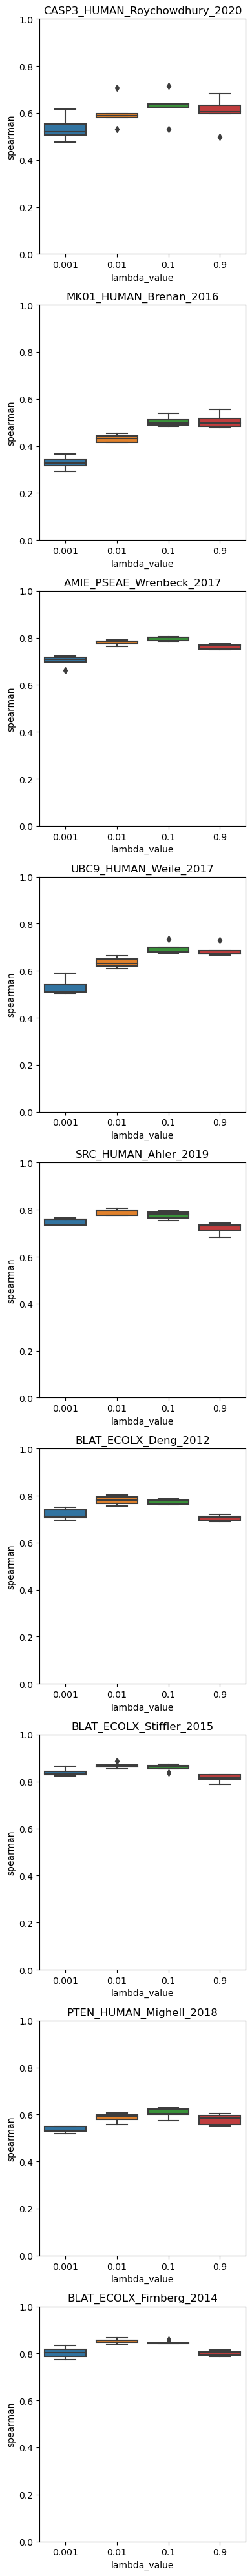

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=len(datasets), figsize=(4, 40))
for i, dataset in enumerate(datasets):
    df = results_df[results_df["dataset"] == dataset]

    sns.boxplot(df, x="lambda_value", y="spearman", ax=ax[i])
    ax[i].set_title(dataset)
    ax[i].set_ylim([0, 1])
fig.tight_layout()

In [11]:
embeddings

array([[ 0.12231576, -0.31926343,  0.04499417, ..., -0.01062659,
        -0.07151157, -0.0691978 ],
       [ 0.14705995, -0.29927856,  0.03668432, ..., -0.01023824,
        -0.07035129, -0.06392057],
       [ 0.14043245, -0.32056648,  0.05078109, ..., -0.01230102,
        -0.07228594, -0.07963827],
       ...,
       [ 0.11340933, -0.3055205 ,  0.03245023, ..., -0.00495341,
        -0.07467657, -0.06221331],
       [ 0.11306834, -0.30605835,  0.03152068, ..., -0.03427316,
        -0.08053635, -0.06512277],
       [ 0.11362512, -0.30482   ,  0.03240107, ..., -0.00299828,
        -0.07780246, -0.06156464]])

In [72]:
# Potts
results = {
    "dataset": [],
    "model": [],
    "fold": [],
    "lambda_value": [],
    "spearman": [],
}
for ds in datasets:
    logger.info(f"Starting experiment on {ds}.")
    data = pd.read_csv(DATA_ROOT / f"{ds}/data.csv").reset_index()
    data["position"] = data["mutant"].map(lambda x: int(x[1:-1]))
    with TemporaryDirectory() as temp_dir:
        potts_path = get_potts_emissions(
            path=temp_dir,
            dataset=ds,
            training_job_names=potts_training_job_names,
            default_bucket=DEFAULT_BUCKET
        )
        data = assign_ssm_folds(data, n_folds=n_folds, position_col="position", random_seed=SEED)
        for test_fold in range(n_folds):
            logger.info(f"Starting fold {test_fold}.")
            train_data = data[data["ssm_fold"] != test_fold]
            test_data = data[data["ssm_fold"] == test_fold]
            for lambda_reg in lambda_values:
                logger.info(f"Testing a lambda value of: {lambda_reg}.")
                model = PottsRegressor(potts_path=Path(potts_path), encoder="energies", alpha=lambda_reg)
                model.fit(train_data, property="DMS_score")
                test_predictions = model.predict(test_data)
                spearman, _ = spearmanr(test_data["DMS_score"].values, test_predictions)
                results["dataset"].append(ds)
                results["model"].append("Augmented Potts")
                results["fold"].append(test_fold)
                results["lambda_value"].append(lambda_reg)
                results["spearman"].append(spearman)

2024-02-14 14:32:01.592 | INFO     | __main__:<module>:10 - Starting experiment on CASP3_HUMAN_Roychowdhury_2020.
2024-02-14 14:32:45.245 | INFO     | __main__:<module>:22 - Starting fold 0.
2024-02-14 14:32:45.246 | INFO     | __main__:<module>:26 - Testing a lambda value of: 0.001.
2024-02-14 14:32:45.247 | INFO     | predictability.models:__init__:150 - Loading Potts model locally from: /var/folders/d8/bxgj52rj3w934zctbjr8v2hh0000gn/T/tmpn57swzs6
2024-02-14 14:32:46.780 | INFO     | __main__:<module>:26 - Testing a lambda value of: 0.01.
2024-02-14 14:32:46.781 | INFO     | predictability.models:__init__:150 - Loading Potts model locally from: /var/folders/d8/bxgj52rj3w934zctbjr8v2hh0000gn/T/tmpn57swzs6
2024-02-14 14:32:48.331 | INFO     | __main__:<module>:26 - Testing a lambda value of: 0.1.
2024-02-14 14:32:48.334 | INFO     | predictability.models:__init__:150 - Loading Potts model locally from: /var/folders/d8/bxgj52rj3w934zctbjr8v2hh0000gn/T/tmpn57swzs6
2024-02-14 14:32:49.835

In [74]:
results_df = pd.DataFrame(results)

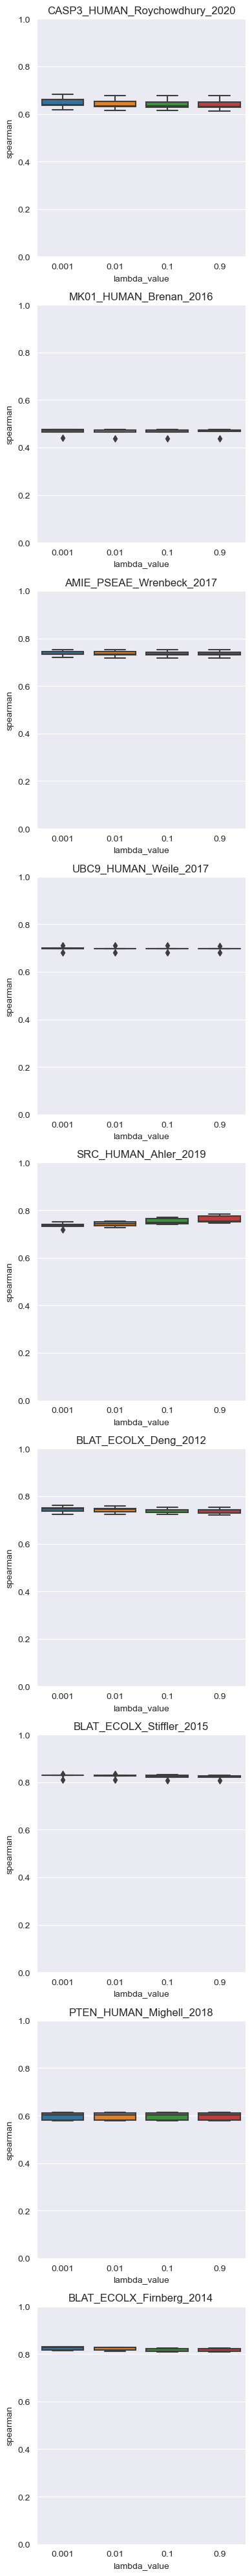

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=len(datasets), figsize=(4, 40))
for i, dataset in enumerate(datasets):
    df = results_df[results_df["dataset"] == dataset]

    sns.boxplot(df, x="lambda_value", y="spearman", ax=ax[i])
    ax[i].set_title(dataset)
    ax[i].set_ylim([0, 1])
fig.tight_layout()

1. Prepare PE datasets for all datasets (skip asp and amye for now)
2. Run training jobs separately for all datasets in protest dir
3. Copy training job names and put in this notebook
4. Create function for downloading embeddings and potts params
5. Write evaluation loop